#### Imports

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

%matplotlib inline

#### Import Data

In [2]:
with np.load("notMNIST.npz") as data:
    images, labels = data["images"], data["labels"]

In [3]:
num_classes = labels.max() - labels.min() + 1
num_classes

10

In [4]:
images.shape

(28, 28, 18720)

In [5]:
images.T.shape

(18720, 28, 28)

In [6]:
labels.shape

(18720, 1)

In [7]:
temp_img = images.T[1].T
temp_img.shape

(28, 28)

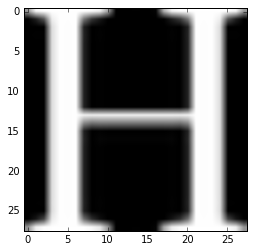

In [8]:
plt.imshow(temp_img, cmap=plt.gray())

In [9]:
print labels[1]

[7]


## Logistic Regression w/ Softmax

- Softmax output layer
- Log likelihood objective function
- Train with no reg., SGD and momentum
- Find good value for momentum hyper
- Plot log likelihood / errors of training and valid vs number of epochs
- Determine best time to stop training, and compute test errors on it

$$y(\mathbf{x}, \mathbf{w}) = \sigma (\mathbf{x}^T \mathbf{w} + b)$$

#### Set up data

In [10]:
images_re = images.reshape((images.shape[0] * images.shape[1], images.shape[2])).T
images_re.shape

(18720, 784)

In [11]:
training_size = 15000
validation_size = 1000

In [12]:
train_x = images_re[:training_size]
valid_x = images_re[training_size:training_size + validation_size]
test_x = images_re[training_size + validation_size:]

#### Create one-hot labels

In [13]:
labels.size

18720

In [14]:
labels[:10]

array([[4],
       [7],
       [5],
       [9],
       [9],
       [1],
       [0],
       [8],
       [5],
       [5]], dtype=uint8)

In [15]:
num_examples = labels.size
labels_one_hot = np.zeros((num_examples, labels.max() - labels.min() + 1))
labels_one_hot[np.arange(num_examples), labels[:num_examples].ravel()] = 1

In [16]:
labels_one_hot[:10]

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [17]:
train_y = labels_one_hot[:training_size]
valid_y = labels_one_hot[training_size:training_size + validation_size]
test_y = labels_one_hot[training_size + validation_size:]

#### Try sklearn

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(train_x, labels[:training_size].ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
lr.score(train_x, labels[:training_size].ravel())

0.93786666666666663

In [27]:
lr.score(valid_x, labels[training_size:training_size + validation_size].ravel())

0.878

In [29]:
lr.score(test_x, labels[training_size + validation_size:].ravel())

0.87169117647058825

#### Set up TF variables

In [18]:
image_pixels = 28 * 28

In [49]:
#Placeholders
X = tf.placeholder("float", shape=(None, image_pixels))
Targets = tf.placeholder("float", shape=(None, num_classes))

#Variables
W = tf.Variable(np.random.randn(image_pixels, num_classes).astype("float32"), name="weight")
b = tf.Variable(np.random.randn(num_classes).astype("float32"), name="bias")

In [50]:
logits = tf.add(tf.matmul(X, W), b)
Y = tf.nn.softmax(logits)

In [51]:
Y.get_shape()

TensorShape([Dimension(None), Dimension(10)])

#### Try with CE loss function

In [52]:
cost_batch = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Targets)
cost = tf.reduce_mean(cost_batch)

In [97]:
learning_rate = 0.0001
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.01)
train_op = optimizer.minimize(cost)

In [98]:
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Targets,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float32"))

In [55]:
correct_prediction.get_shape()

TensorShape([Dimension(None)])

In [72]:
sess = tf.InteractiveSession()

In [127]:
init = tf.initialize_all_variables()

In [128]:
sess.run(init)

In [129]:
num_epochs = 250
mini_batch_size = 100

In [130]:
train_accuracy = []
train_cost = []
valid_accuracy = []
valid_cost = []

In [131]:
for epoch in range(num_epochs): 
    for i in range(training_size / mini_batch_size):
        batch_x = train_x[i * mini_batch_size: (i + 1) * mini_batch_size]
        batch_y = train_y[i * mini_batch_size: (i + 1) * mini_batch_size]

        cost_mb, _ = sess.run([cost, train_op], feed_dict={X: batch_x, Targets: batch_y})
        
    # Evaluate per epoch
    cost_train, accuracy_train = sess.run([cost, accuracy], feed_dict={X: train_x, Targets: train_y})
    cost_valid, accuracy_valid = sess.run([cost, accuracy], feed_dict={X: valid_x, Targets: valid_y})
    
    train_cost.append(cost_train)
    train_accuracy.append(accuracy_train)

    valid_cost.append(cost_valid)
    valid_accuracy.append(accuracy_valid)   

In [132]:
print(sess.run(accuracy, feed_dict={X: test_x, Targets: test_y}))

0.830515


In [133]:
len(train_error)

200

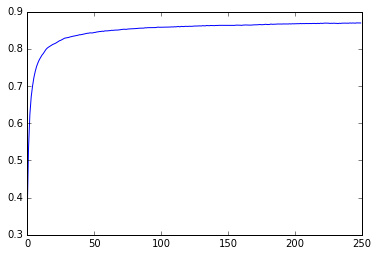

In [134]:
plt.plot(np.arange(num_epochs), train_accuracy)

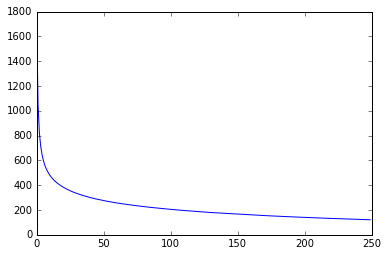

In [135]:
plt.plot(np.arange(num_epochs), train_cost)

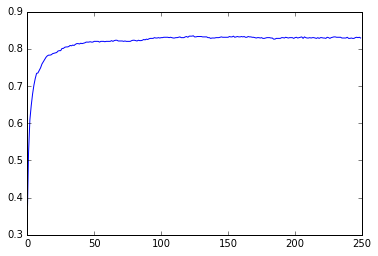

In [136]:
plt.plot(np.arange(num_epochs), valid_accuracy)

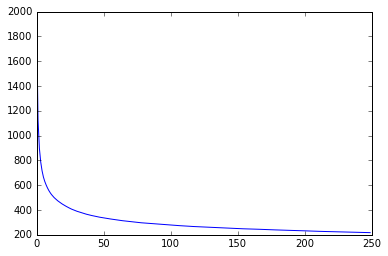

In [137]:
plt.plot(np.arange(num_epochs), valid_cost)

In [71]:
sess.close()

### Neural Network
- RELU activation function
- softmax for output layer
- Cross entropy (log likelihood) as cost function

##### Helper functions

In [151]:
def weight_var(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_var(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

##### One hidden layer of 1000 units

In [152]:
hidden_units = 100

In [153]:
X_nn = tf.placeholder("float", shape=(None, image_pixels))
Targets_nn = tf.placeholder("float", shape=(None, num_classes))

In [154]:
Targets_nn.get_shape()

TensorShape([Dimension(None), Dimension(10)])

In [155]:
W1_nn = weight_var([image_pixels, hidden_units])
W2_nn = weight_var([hidden_units, num_classes])
b1_nn = bias_var([hidden_units])
b2_nn = bias_var([num_classes])

In [156]:
H_nn = tf.nn.relu(tf.matmul(X_nn, W1_nn) + b1_nn)
logits_nn = tf.matmul(H_nn, W2_nn) + b2_nn
Y_nn = tf.nn.softmax(logits_nn)

In [157]:
Y_nn.get_shape()

TensorShape([Dimension(None), Dimension(10)])

In [158]:
cost_batch_nn = tf.nn.softmax_cross_entropy_with_logits(logits=logits_nn, labels=Targets_nn)
cost_nn = tf.reduce_mean(cost_batch_nn)

In [159]:
learning_rate_nn = 0.0005
optimizer_nn = tf.train.GradientDescentOptimizer(learning_rate_nn)
train_op_nn = optimizer_nn.minimize(cost_nn)

In [160]:
correct_prediction_nn = tf.equal(tf.argmax(Y_nn,1), tf.argmax(Targets_nn,1))
accuracy_nn = tf.reduce_mean(tf.cast(correct_prediction_nn, "float32"))

In [27]:
sess_nn = tf.InteractiveSession()

In [161]:
init_nn = tf.initialize_all_variables()
sess_nn.run(init_nn)

In [162]:
num_epochs = 100

In [163]:
train_cost = []
train_acc = []

In [164]:
for epoch in range(num_epochs):
    cost_per_epoch, acc_per_epoch, _ = sess_nn.run([cost_nn, accuracy_nn, train_op_nn], feed_dict={X_nn: train_x, Targets_nn: train_y})
    train_cost.append(cost_per_epoch)
    train_acc.append(acc_per_epoch)

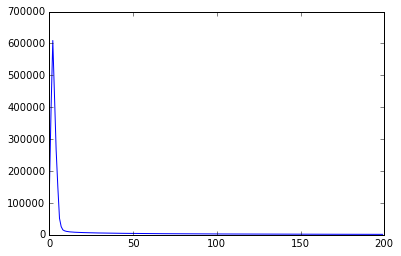

In [134]:
plt.plot(np.arange(num_epochs), train_cost)

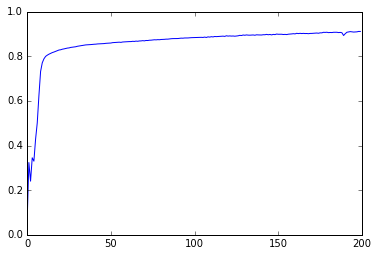

In [135]:
plt.plot(np.arange(num_epochs), train_acc)

In [136]:
sess_nn.run(accuracy_nn, feed_dict={X_nn: train_x, Targets_nn: train_y})

0.91073334

In [137]:
sess_nn.run(accuracy_nn, feed_dict={X_nn: valid_x, Targets_nn: valid_y})

0.85399997

In [138]:
sess_nn.run(accuracy_nn, feed_dict={X_nn: test_x, Targets_nn: test_y})

0.85147059

##### Two layers of 500 units each

In [ ]:
hidden_units = 500

In [ ]:
W1_nn = weight_var([image_pixels, hidden_units])
W2_nn = weight_var([hidden_units, hidden_units])
W3_nn = weight_var([hidden_units, num_classes])

b1_nn = bias_var([hidden_units])
b2_nn = bias_var([hidden_units])
b3_nn = bias_var([num_classes])

In [ ]:
H1_nn = tf.nn.relu(tf.matmul(X_nn, W1_nn) + b1_nn)
H2_nn = tf.nn.relu(tf.matmul(H1_nn, W2_nn) + b2_nn)
logits_nn = tf.matmul(H2_nn, W3_nn) + b3_nn
Y_nn = tf.nn.softmax(logits_nn)

###### One layer of 1000 hidden units, with dropout

In [ ]:
keep_prob = tf.placeholder(tf.float32)
H_nn_drop = tf.nn.dropout(H_nn, keep_prob)
logits_nn = tf.matmul(H_nn_drop, W2_nn) + b2_nn